In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import string
import numpy as np
import easyocr
import collections
import tensorflow as tf
import torch
import gc
from PIL import Image, ImageColor, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from pprint import pprint
from tqdm import tqdm
from glob import glob

# Define OCR

In [2]:
# Initialize OCR
reader = easyocr.Reader([], gpu=True)

# Define rendering

In [3]:
def generate_text(_char):
    return _char * 4

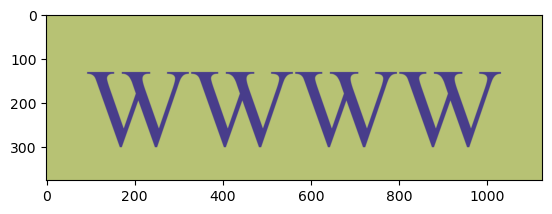

In [4]:
def draw_char(char, typeface, size):
    # Set canvas size
    W, H = (int(size * 1.5) * 3, int(size * 1.5))
    # Set font
    font = ImageFont.truetype(typeface, size)
    # Make empty image
    img = Image.new('RGB', (W, H), color='#B7C274')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2,(H-h)/2), char, fill='#483d8b', font=font)

    return np.asarray(img)

img = draw_char(generate_text("W"), '../inputs/times.ttf', 250)
plt.imshow(img)
plt.show()

# Define error with non lowercasing

In [71]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)

# Setup problematic font map
hashmap = dict()

# Loop through characters
for char in tqdm(chars):
    # Render characters
    img = draw_char(generate_text(char), '../inputs/times.ttf', 50)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)

    # If character detected
    if len(result) > 0:
        # Calculate most character appear
        most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
        # If char not the same
        if most_char != char:
            # Add to hash map
            hashmap[char] = most_char

print("Total error", len(hashmap))

100%|██████████| 62/62 [00:03<00:00, 20.17it/s]

Total error 8


0oo0
0 --> o


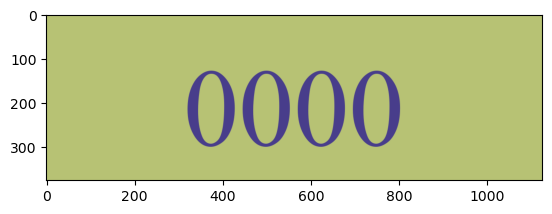

qqqq
q --> 9


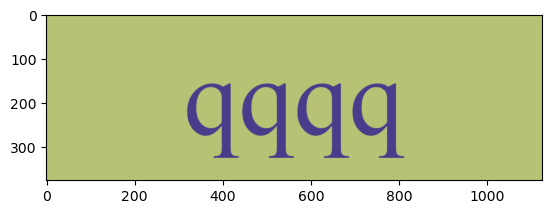

SSSS
s --> S


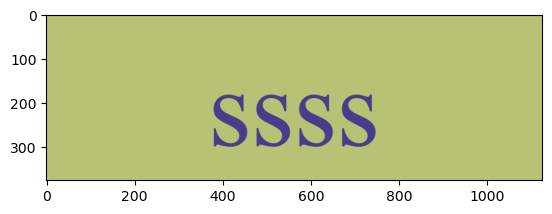

VVVV
v --> V


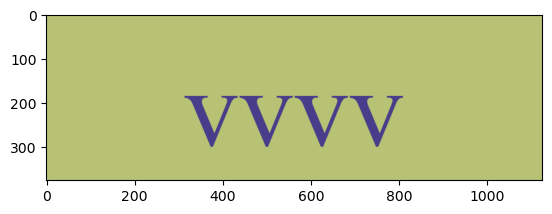

WWWW
w --> W


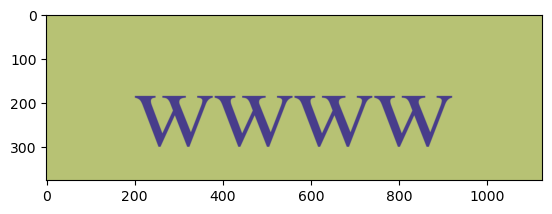

XXXX
x --> X


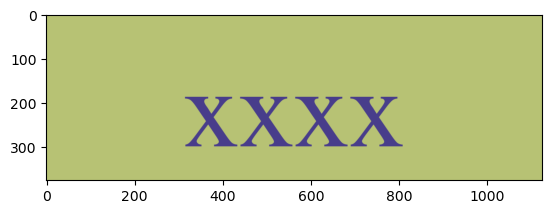

ZZZZ
z --> Z


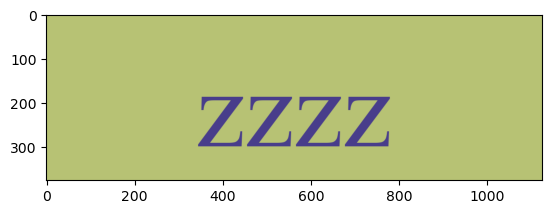

OOOO
O --> o


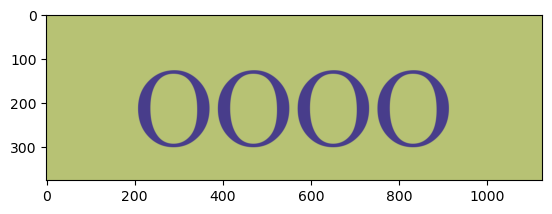

In [72]:
for char, most_char in hashmap.items():
    # Render characters
    img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)
    print(result[0][1])

    # Print char
    print(char, "-->", most_char)
    plt.imshow(img, cmap='gray')
    plt.show()

# Define error with lowercasing

In [7]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)

# Setup problematic font map
hashmap = dict()

# Loop through characters
for char in tqdm(chars):
    # Render characters
    img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)

    # If character detected
    if len(result) > 0:
        # Calculate most character appear
        most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
        # If char not the same
        if most_char.lower() != char.lower():
            # Add to hash map
            hashmap[char] = most_char

        # if result[0][1] != generate_text(char):
        #     print(char, "-->", result[0][1])
        #     plt.imshow(img, cmap='gray')
        #     plt.show()
    else:
        plt.imshow(img, cmap='gray')
        plt.show()
        raise Exception(f"{char} not detected")

print("Total error", hashmap)

100%|██████████| 62/62 [00:04<00:00, 12.55it/s]

Total error {}


0 --> 0oo0


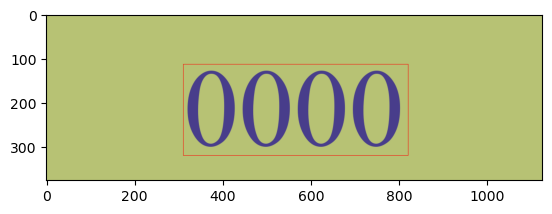

In [184]:
# Render characters
img = draw_char(generate_text('0'), '../inputs/times.ttf', 250)
# Detect characters with OCR
result = reader.readtext(img, allowlist=chars)
# Draw bounding box
img = Image.fromarray(np.uint8(img)).convert('RGB')
draw = ImageDraw.ImageDraw(img)
for item in result:
    top_left = (item[0][0][0], item[0][0][1])
    bottom_right = (item[0][2][0], item[0][2][1])
    draw.rectangle((top_left, bottom_right), outline='red')
    # Print char
    print('0', "-->", result[0][1])

plt.imshow(img, cmap='gray')
plt.show()

# Define error with lowercasing tensorflow

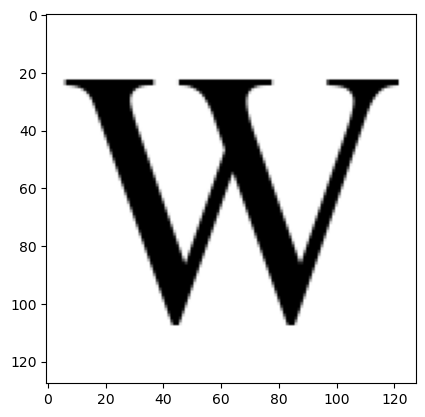

In [3]:
def draw_square_char(char, font, size=128, fontsize=125):
    # Set canvas size
    W, H = size, size
    # Set font
    font = ImageFont.truetype('../inputs/times.ttf', fontsize)
    # Make empty image
    img = Image.new('RGB', (W, H), color='white')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2, ((H-h)/2)-size/10), char, 0, font=font)

    return np.asarray(img)

img = draw_square_char('W', '../inputs/times.ttf')
plt.imshow(img, cmap='gray')
plt.show()

In [4]:
model = tf.keras.models.load_model('../models/model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 62)                15934     
                                                        

In [5]:
# Get list possible character
class_names = ['100','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','48','49','50','51','52','53','54','55','56','57','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90','97','98','99']

# Get list possible character
chars = list(string.digits + string.ascii_letters)

# Render
images = np.array([draw_square_char(char, '../inputs/times.ttf') for char in chars])

# Predict
predictions = model.predict(images, verbose=0, batch_size=32)
predictions = np.argmax(predictions, axis=1)
result = "".join([chr(int(class_names[pred])) for pred in predictions])

print("".join(chars))
print(result)
print("".join(chars) == result)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
True


# Generate image

In [17]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)
size = 128
fontsize = 100

for char in chars:
    # Set canvas size
    W, H = size, size
    # Set font
    font = ImageFont.truetype('../inputs/times.ttf', fontsize)
    # Make empty image
    img = Image.new('L', (W, H), color='white')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2, ((H-h)/2)-size/10), char, 0, font=font)

    os.mkdir("../chars/" + str(ord(char)))
    img.save("../chars/" + str(ord(char)) + "/original.jpg")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../chars/48'

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

for f in tqdm(glob('../chars/*/*.jpg')):
    img = load_img(f)
    x = img_to_array(img)
    # Reshape the input image
    x = x.reshape((1, ) + x.shape)
    i = 0

    # generate 5 new augmented images
    for batch in datagen.flow(x, batch_size = 1,
                              save_to_dir = os.path.dirname(f),
                              save_prefix = 'augmented', save_format ='jpg'):
        i += 1
        if i > 250:
            break

100%|██████████| 62/62 [01:09<00:00,  1.11s/it]


# Testing color

In [164]:
def get_complementary(color):
    if not isinstance(color, str):
        r,g,b = color
        color = "#%02x%02x%02x" % (r,g,b)

    color = color[1:]
    color = int(color, 16)
    comp_color = 0xFFFFFF ^ color
    comp_color = "#%06X" % comp_color
    return comp_color

In [165]:
colors1 = list(ImageColor.colormap.values())
colors2 = [get_complementary(color) for color in colors1]
# pairs = result = [(c1, c2) for c1 in colors for c2 in colors if c1 != c2]
pairs = list(zip(colors1 + colors2, colors2 + colors1))

In [166]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)
hashmaps = []

with tqdm(total=len(pairs) * len(chars)) as pbar:
    for fg, bg in pairs:
        def draw_char(char, typeface, size):
            # Set canvas size
            W, H = (int(size * 1.5) * 3, int(size * 1.5))
            # Set font
            font = ImageFont.truetype(typeface, size)
            # Make empty image
            img = Image.new('RGB', (W, H), color=bg)
            # Draw text to image
            draw = ImageDraw.Draw(img)
            _, _, w, h = font.getbbox(char)
            draw.text(((W-w)/2,(H-h)/2), char, fill=fg, font=font)

            return np.asarray(img)

        # Setup problematic font map
        hashmap = dict()

        # Loop through characters
        for char in chars:
            # Render characters
            img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
            # Detect characters with OCR
            result = reader.readtext(img, allowlist=chars)

            # If character detected
            if len(result) > 0 and len(result[0][1]) > 0:
                # Calculate most character appear
                most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
                # If char not the same
                if most_char.lower() != char.lower():
                    # Add to hash map
                    hashmap[char] = most_char
            else:
                hashmap[char] = ''

            # Update progress bar
            pbar.update(1)

        hashmaps.append(hashmap)

100%|██████████| 18352/18352 [24:16<00:00, 12.60it/s]


In [167]:
hashmaps_count = np.array([len(el) for el in hashmaps])

In [168]:
np.where(hashmaps_count == 0)[0]

array([], dtype=int64)

In [172]:
np.array(hashmaps)[np.where(hashmaps_count == 1)[0]]

array([{'o': '0'}, {'o': '0'}, {'0': 'o'}, {'0': 'o'}, {'0': 'o'},
       {'0': 'o'}, {'1': 'l'}, {'1': 'l'}, {'q': '9'}, {'0': 'o'},
       {'0': 'o'}, {'0': 'o'}, {'0': 'o'}, {'0': 'o'}, {'0': 'o'},
       {'0': 'o'}, {'0': 'o'}, {'0': 'o'}, {'q': '9'}, {'0': 'o'},
       {'0': 'o'}, {'0': 'o'}], dtype=object)

In [23]:
for index in np.where(hashmaps_count == 0)[0]:
    fg, bg = pairs[index]

    def draw_char(char, typeface, size):
        # Set canvas size
        W, H = (int(size * 1.5) * 3, int(size * 1.5))
        # Set font
        font = ImageFont.truetype(typeface, size)
        # Make empty image
        img = Image.new('RGB', (W, H), color=bg)
        # Draw text to image
        draw = ImageDraw.Draw(img)
        _, _, w, h = font.getbbox(char)
        draw.text(((W-w)/2,(H-h)/2), char, fill=fg, font=font)

        return np.asarray(img)

    # Setup problematic font map
    hashmap = dict()

    # Loop through characters
    for char in chars:
        # Render characters
        img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
        # Detect characters with OCR
        result = reader.readtext(img, allowlist=chars)

        # If character detected
        if len(result) > 0 and len(result[0][1]) > 0:
            # Calculate most character appear
            most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
            # If char not the same
            if most_char.lower() != char.lower():
                # Add to hash map
                hashmap[char] = most_char

    print(fg, bg, hashmap)

    for char, most_char in hashmap.items():
        # Render characters
        img = draw_char(generate_text(char), '../inputs/times.ttf', 250)

        # Print char
        print(char, "-->", most_char)
        plt.imshow(img, cmap='gray')
        plt.show()

#5f9ea0 #A0615F {}
#483d8b #B7C274 {}
#2e8b57 #D174A8 {}
#ee82ee #117D11 {}
#424894 #bdb76b {}
#AA94D0 #556b2f {}
#969696 #696969 {}
#969696 #696969 {}
#0F7F7F #f08080 {}
#005F85 #ffa07a {}
#437070 #bc8f8f {}


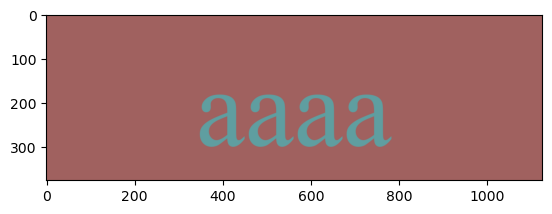

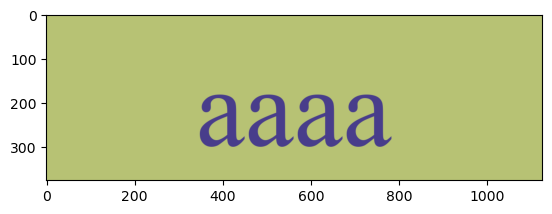

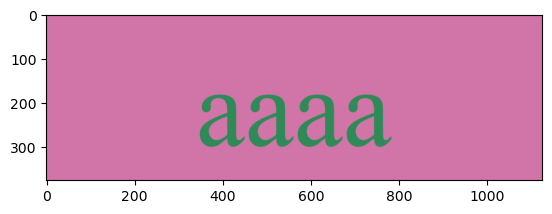

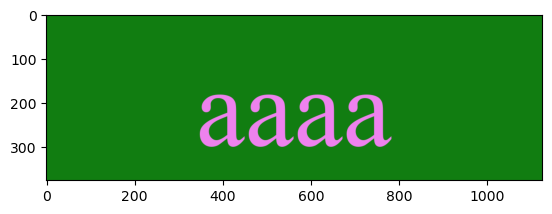

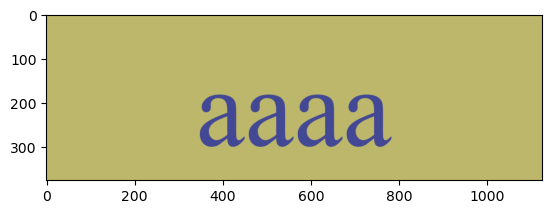

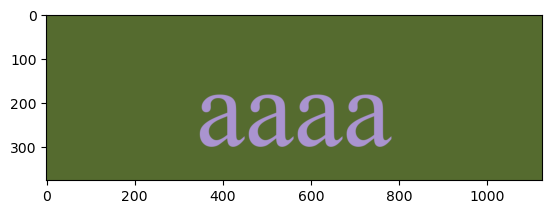

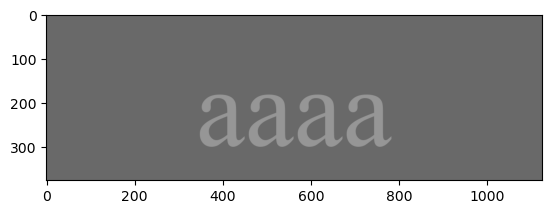

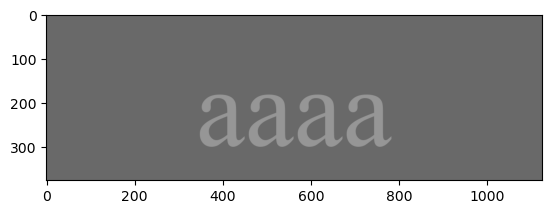

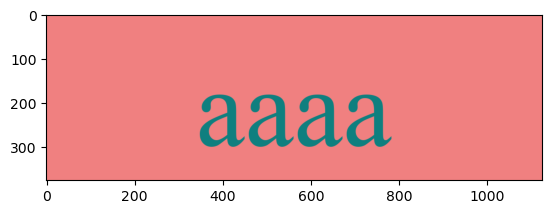

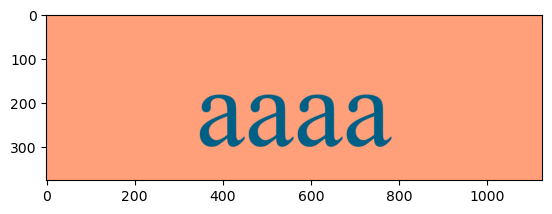

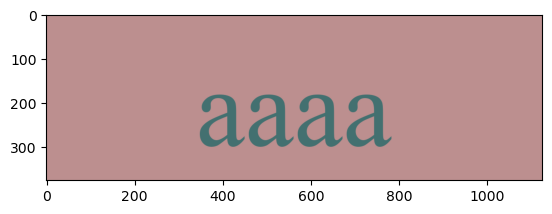

In [24]:
for index in np.where(hashmaps_count == 0)[0]:
    fg, bg = pairs[index]

    def draw_char(char, typeface, size):
        # Set canvas size
        W, H = (int(size * 1.5) * 3, int(size * 1.5))
        # Set font
        font = ImageFont.truetype(typeface, size)
        # Make empty image
        img = Image.new('RGB', (W, H), color=bg)
        # Draw text to image
        draw = ImageDraw.Draw(img)
        _, _, w, h = font.getbbox(char)
        draw.text(((W-w)/2,(H-h)/2), char, fill=fg, font=font)

        return np.asarray(img)

    # Render characters
    img = draw_char(generate_text('a'), '../inputs/times.ttf', 250)

    # Print char
    plt.imshow(img, cmap='gray')
    plt.show()

# Analyze individual font

In [1]:
from fontTools.ttLib import TTFont

def char_in_font(unicode_char, font):
    for cmap in font['cmap'].tables:
        if cmap.isUnicode():
            if ord(unicode_char) in cmap.cmap:
                return True
    return False

In [177]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)

8 --> WWWW


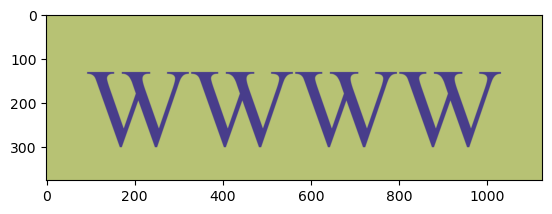

e --> pppp


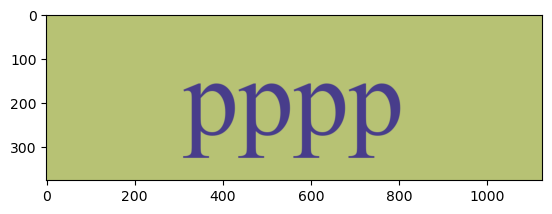

l --> eeee


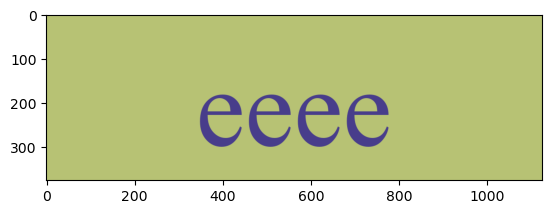

o --> gggg


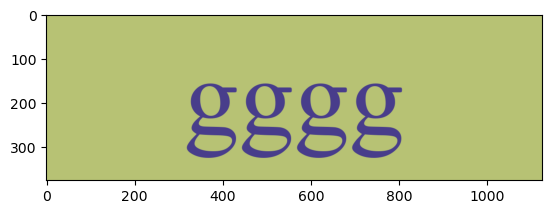

p --> yyyy


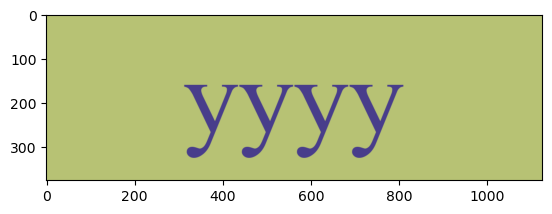

v --> jjjj


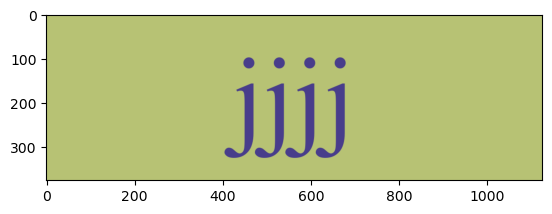

x --> 2222


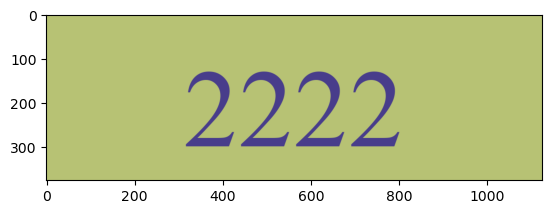

y --> XXXX


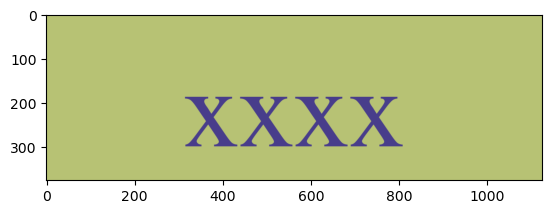

D --> Illl


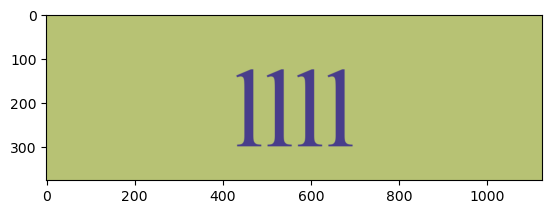

F --> TTTT


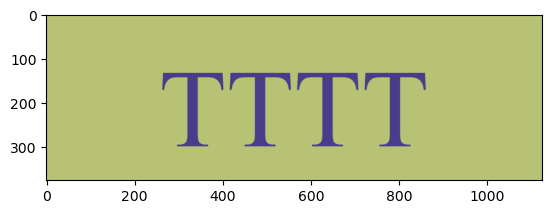

H --> 1111


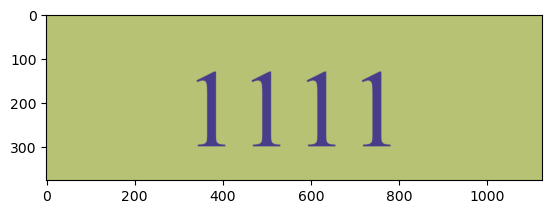

K --> LLLL


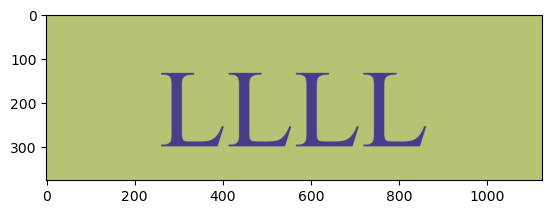

Q --> CCCC


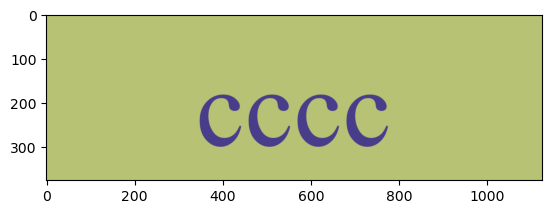

U --> VVVV


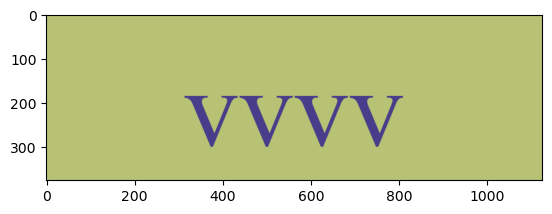

W --> o00o


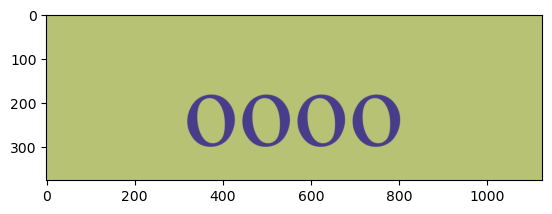

In [178]:
for char in chars:
    font = TTFont("../fonts/e86678460e151a6e44ebfabbc184661e.ttf")
    if not char_in_font(char, font):
        continue

    # Render characters
    img = draw_char(generate_text(char), "../fonts/e86678460e151a6e44ebfabbc184661e.ttf", 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)

    if len(result) > 0:
        most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
        # If char not the same
        if most_char.lower() != char.lower():
            # Print char
            print(char, '-->', result[0][1])
            plt.imshow(img, cmap='gray')
            plt.show()